# IMPORTING AND CONFIGURING LIBRAIRIES

In [1]:
import math
import pandas as pd
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import OffsetFrom
import os
import warnings
from scipy import stats
import pingouin as pg
from mystats import statistics, ConfidencePlotter
import sys
from anytree import Node, RenderTree
from utils import *
from IPython.display import display, HTML

# Get the current working directory
cwd = os.getcwd()
imgDir = 'img'
pathToImgDir = os.path.join(cwd, imgDir)
filename_head = 'study2'
filename_extension = 'jpg'
figure_dpi = 300
# Ignore all warning for clean output
warnings.simplefilter("ignore")

c:\Python38\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\Users\m.daniel\workspace\ExpanDialSticks\Python\study2\mystats\statistics.py:1100: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (normality_assumption is 'auto' and allColumnsAreNormal) or (normality_assumption is 'true'):
c:\Users\m.daniel\workspace\ExpanDialSticks\Python\study2\mystats\statistics.py:1100: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (normality_assumption is 'auto' and allColumnsAreNormal) or (normality_assumption is 'true'):


# FETCHING QUANTITATIVE AND QUALITATIVE DATAFRAMES

In [2]:
# Quantitative Dataframes
INPUT_COLUMN_NAMES = [ 
    'Date', 'Participant', 'Task', 'Modality', 'Trial' , 
    'Target_X', 'Target_Y', 'Density',
    'SC_Count_Mean', 'SC_Count_SD', 'SC_Count_Max', 'SC_Count_Min',
    'SC_Amplitude_Mean', 'SC_Amplitude_SD', 'SC_Amplitude_Max', 'SC_Amplitude_Min',
    # eda event-related features
    'EDA_Response_Count',
    'EDA_Response_Mean',
    'EDA_Response_SD',
    'EDA_Response_Max',
    'EDA_Response_Min',

    'EDA_Level_Mean',
    'EDA_Level_SD',
    'EDA_Level_Max',
    'EDA_Level_Min',

     # ppg event-related features
    'BVP_Peak_Count',
    'BVP_Peak_Mean',
    'BVP_Peak_SD',
    'BVP_Peak_Max',
    'BVP_Peak_Min',

    'BVP_Rate_Mean',
    'BVP_Rate_SD',
    'BVP_Rate_Max',
    'BVP_Rate_Min'
    ]
parse_directory = "parse"
quant_file = 'quantitative-description.csv'
df_quant = pd.read_csv(os.path.join(parse_directory, quant_file))
column_name_diff = list(set(df_quant.columns.values.tolist()) - set(INPUT_COLUMN_NAMES))
if len(column_name_diff) != 0:
    err("Missing columns (%s)" %column_name_diff)
    exit()
df_quant['Date'] = pd.to_datetime(df_quant['Date'])
if df_quant.index.duplicated(keep='first').sum(): print("{ERROR] duplicated indexes found!")
CONTROL_NAMES = ['USERO-REST', 'SYSO-REST']
df_quant = df_quant.loc[~df_quant['Modality'].isin(CONTROL_NAMES), :]

# Qualitative Dataframes
data_directory = 'data'
form_directory = 'Forms/all'
demography_filename = "demography.xlsx"
demography_headers = ['DATE','AGE_TO_DELETE', 'SEXE', 'STUDY', 'AGE', 'COBOT', 'COBOT_TO_DELETE']
df_demography = pd.read_excel(os.path.join(data_directory,form_directory, demography_filename ), names=demography_headers)
df_demography = df_demography.drop(columns=['DATE', 'AGE_TO_DELETE', 'COBOT_TO_DELETE'])
df_demography = df_demography.drop(index=[0, 1, 2])
df_demography.reset_index(inplace=True, drop=True)

sequence_filename = 'study2-sequence.xlsx'
stress_filename = "stress-and-safety.xlsx"
form_columns = ['session0', 'session1', 'session2', 'session3']
header_names = ['DATE',
                'INSECURE⇔SECURE', 'ANXIOUS⇔RELAXED', 'UNCOMFORTABLE⇔COMFORTABLE', 'LACK_CONTROL⇔IN_CONTROL', 'THREATENING⇔SAFE', 'UNFAMILIAR⇔FAMILIAR', 'UNRELIABLE⇔RELIABLE', 'SCARY⇔CALMING',
                'OBSTRUCTIVE⇔SUPPORTIVE', 'COMPLICATED⇔EASY', 'INEFFICIENT⇔EFFICIENT', 'CONFUSING⇔CLEAR', 'BORING⇔EXCITING', 'NOT_INTERESTING⇔INTERESTING', 'CONVENTIONAL⇔INVENTIVE', 'USUAL⇔LEADING_EDGE',
                'UNPREDICTABLE⇔PREDICTABLE', 'EGOISTIC⇔ALTRUISTIC', 'PROTECTING_ROBOT⇔PROTECTING_USER']

df_qual = pd.read_excel(os.path.join(data_directory,form_directory, stress_filename ), names=header_names)

df_seq = pd.read_excel(sequence_filename, index_col=0)
participants_indexes = []
tasks_indexes = []
modalities_indexes = []

for index, row in df_qual.iterrows():
    session_index = int(index % 4)
    participant_index = int(index / 4)
    #print("%s:%s" %(participant_index, session_index))
    sequence_tag = df_seq.iloc[participant_index][session_index]
    task = sequence_tag.split('-')[0]
    modality = sequence_tag.split('-')[1]
    participants_indexes.append(participant_index)
    tasks_indexes.append(task)
    modalities_indexes.append(modality)
df_qual.insert(1, "Modality", modalities_indexes)
df_qual.insert(1, "Task", tasks_indexes)
df_qual.insert(1, "Participant", participants_indexes)


factor_values_labels_map = {
    'Task':{
        'values':['SYSI', 'USERI'],
        'labels':['Interrupt_{system}', 'Interrupt_{user}'],
        },
    'Modality':{
        'values':['SYSO', 'USERO'],
        'labels':['Zone_{system}', 'Zone_{user}'],
        },
    'Density':{
        'values':[9, 19, 29],
        'labels':['Density_{33\%}', 'Density_{66\%}', 'Density_{100\%}'],
        }
}


In [3]:
pin_mass = 0.2 # pin mass in kg
pin_accel = 0.075 # robot speed in m/s²
pin_force = pin_accel * pin_mass
print("pin force: %s kg-m/s²" % pin_force)

Kh = 250 # human speed in mm/s -> 15mph (TO JUSTIFY)
Kr = 75 # robot speed in mm/s 
Tr = 0.100 # 50fps in precision mode + time for computation (TO MEASURE) - Reaction time to detect human and issue a stop – a parameter measured during timing test in s
Tb = 0.100 # Brake time in s (TO MEASURE)
B = 6.25 # brake distance in mm (150mm/24 steps)
C = 5 # 5mm accuracy of leap motion (TO MEASURE) CH + CR, the region surrounding the human and robot respectively. For the testbed, this region includes the uncertainty in position and dimension of each. 
S = Kh*(Tr + Tb) + (Kr * Tr) + B + C
print('Minimum separation distance: %smm' % S)

pin force: 0.015 kg-m/s²
Minimum separation distance: 68.75mm


# ANALYSIS OF USER EXPERIENCE SCORES

           Bad Below Average Above Average  Good Excellent
variable  1.59          0.39          0.33  0.27      0.92




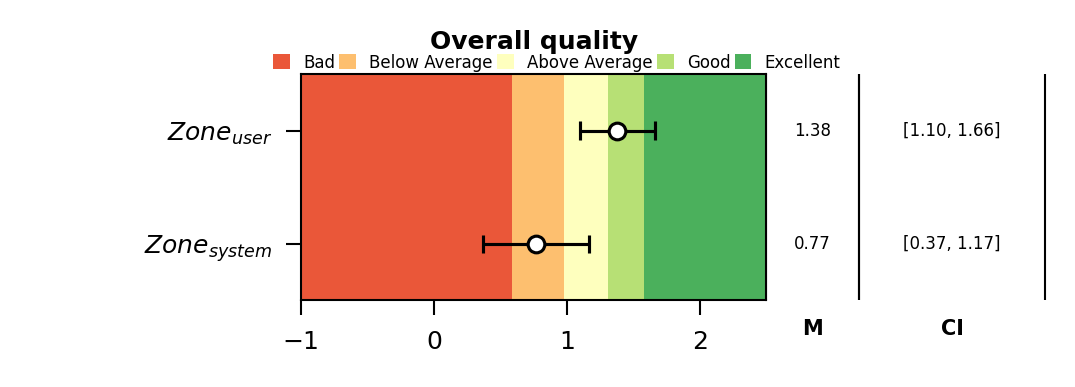

,USERO,SYSO
count,32.000,32.00
mean,1.379,0.77
cil,1.110,0.39
cih,1.640,1.16


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,True,Wilcoxon,86.0,0.003,0.63


           Bad Below Average Above Average  Good Excellent
variable  1.72          0.45          0.38  0.19      0.76




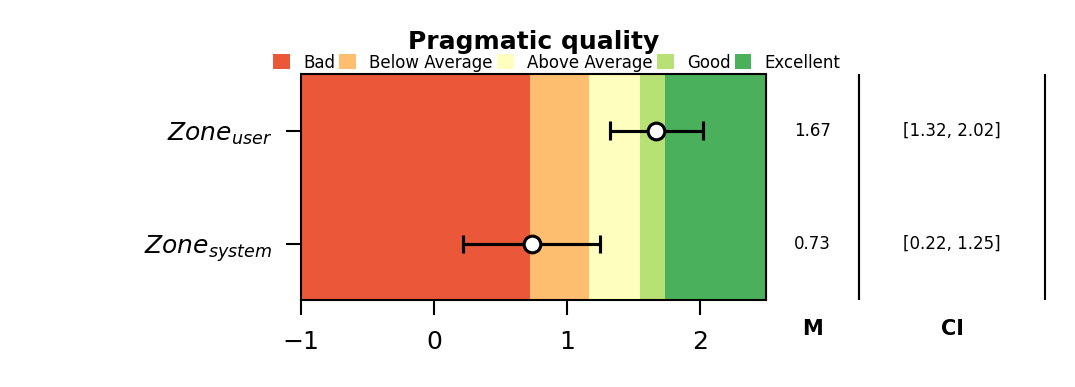

,USERO,SYSO
count,32.000,32.000
mean,1.672,0.734
cil,1.320,0.280
cih,1.990,1.230


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,False,Wilcoxon,65.0,0.003,0.656


           Bad Below Average Above Average  Good Excellent
variable  1.35           0.5          0.35  0.39      0.91




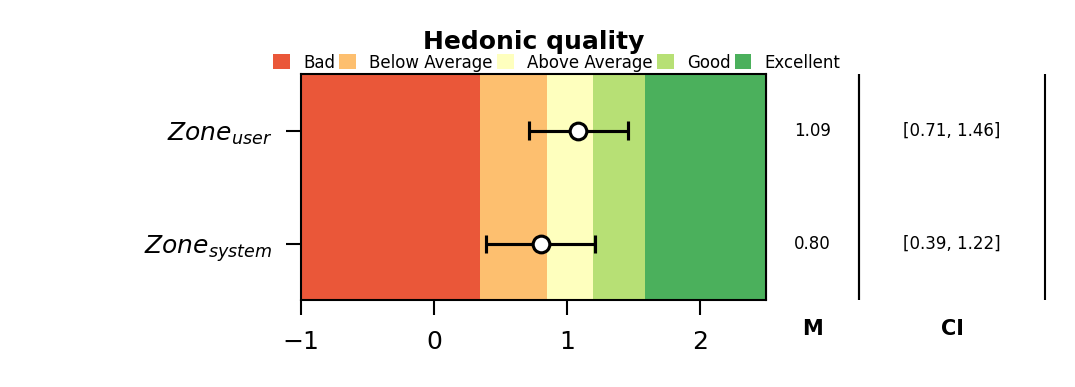

,USERO,SYSO
count,32.000,32.000
mean,1.086,0.805
cil,0.730,0.440
cih,1.430,1.200


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,True,Wilcoxon,91.0,0.032,0.481


In [4]:
PLOT_SAVING = False
from IPython.display import display, HTML
# Compute UEQ-S 

pragmatic_quality_columns = [
'OBSTRUCTIVE⇔SUPPORTIVE', 'COMPLICATED⇔EASY', 'INEFFICIENT⇔EFFICIENT', 'CONFUSING⇔CLEAR',
]
hedonic_quality_columns = [
'BORING⇔EXCITING', 'NOT_INTERESTING⇔INTERESTING', 'CONVENTIONAL⇔INVENTIVE', 'USUAL⇔LEADING_EDGE',
]
all_quality_columns = pragmatic_quality_columns + hedonic_quality_columns
# compute UEQ-S scores
df_qual['Pragmatic quality'] = (df_qual.loc[:,pragmatic_quality_columns] - 4).mean(axis=1)
df_qual['Hedonic quality'] = (df_qual.loc[:,hedonic_quality_columns] - 4).mean(axis=1)
df_qual['Overall quality'] = (df_qual.loc[:,all_quality_columns] - 4).mean(axis=1)

# benchmark
df_benchmark = pd.DataFrame(
    index=['Pragmatic quality', 'Hedonic quality', 'Overall quality'], 
    columns=['Bad', 'Below Average', 'Above Average', 'Good', 'Excellent']
)
df_benchmark.loc['Pragmatic quality', ::] = [1.72, 0.45, 0.38, 0.19, 0.76]
df_benchmark.loc['Hedonic quality', ::]  = [1.35, 0.5, 0.35, 0.39, 0.91]
df_benchmark.loc['Overall quality', ::] = [1.59, 0.39, 0.33, 0.27, 0.92]

factor_names_list = [['Modality']]
variable_name_list = [ 'Overall quality', 'Pragmatic quality', 'Hedonic quality',]
new_variable_name_list = ['Overall quality', 'Pragmatic quality', 'Hedonic quality', ]
filename_body_list = ['Overall quality', 'Pragmatic quality', 'Hedonic quality', ]
desc_stats_of_interest = ['count', 'mean', 'cil', 'cih']

for factor_names in factor_names_list:
    for variable_index, variable_name in enumerate(variable_name_list):
        # fetch useful information
        new_variable_name = new_variable_name_list[variable_index]
        # generate a title
        variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
        display(HTML("<h1>%s</h1>" %(variable_title)))
        # scope dataframe
        df_var = df_qual.loc[::,factor_names + [variable_name]].reset_index()
        # renaming columns 
        df_var_columns = {}
        for factor_index, factor_name in enumerate(factor_names):
            df_var_columns[factor_name] = "factor%s" % factor_index
        df_var_columns[variable_name] = "variable"
        df_var.rename(columns=df_var_columns, inplace=True)
        factor_columns = [factor_column for factor_column in df_var.columns.values if "factor" in factor_column]
        # # plotting figure
        # if len(factor_columns) == 1:
        #     fig_quant = statistics.Statistics.plotOrdinalMonoFactor(
        #         df_var,
        #         figure_size = (2, 1),
        #         figure_dpi = 300,
        #         factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
        #         factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
        #         variable_column = 'variable',
        #         variable_label = new_variable_name_list[variable_index],
        #         variable_lim = new_variable_range_list[variable_index],
        #         )
        #     plt.show()
        df_var_benchmark = df_benchmark.loc[[variable_name], ::] 
        df_var_benchmark.rename(index={variable_name: 'variable'}, inplace=True)
        print(df_var_benchmark)
        if len(factor_columns) == 1:
            fig_quant = statistics.Statistics.plotQuantMonoFactor(
                df_var,
                figure_size = (2, 1),
                figure_dpi = figure_dpi,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                x_lim = (-1,2.5),
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = df_var_benchmark
                )
            plt.show()
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(filename, bbox_inches='tight', dpi = figure_dpi)
            plt.show()

        if len(factor_columns) == 2:
            fig_quant = statistics.Statistics.plotQuantDualFactors(
                df_var,
                figure_size = (2, 1),
                figure_dpi = 300,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                factor2_columns = factor_values_labels_map[factor_names[1]]['values'],
                factor2_labels = factor_values_labels_map[factor_names[1]]['labels'],
                x_lim = (-1,2.5),
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = df_var_benchmark
                )
            plt.show()
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()
        
        # descriptive statistics
        
        # Pivot factor x variables

        df_var_cpy = df_var.copy()
        df_var_cpy["factor"] = df_var_cpy[factor_columns].apply(lambda x: "-".join([str(_) for _ in x]), axis=1)
        df_var_cpy.drop(columns=factor_columns, inplace=True)
        multifactor_values = df_var_cpy["factor"].unique().tolist()
        df_var_pivot = df_var_cpy.pivot(index="index", columns="factor", values="variable")

        df_var_pivot = pd.DataFrame()
        for multifactor_value in multifactor_values:
            raw_values = df_var_cpy.loc[df_var_cpy['factor'] == multifactor_value, 'variable'].values
            df_var_col = pd.DataFrame({multifactor_value:raw_values})
            df_var_pivot = pd.concat([df_var_pivot,df_var_col],  axis=1)
            
        # descriptive statistics
        df_stats_desc = statistics.Statistics.describePlus(df_var_pivot).round(3)
        display(df_stats_desc.loc[desc_stats_of_interest, ::])
        
        df_stats_infer = statistics.Statistics.inferQuantPaired(df_var_pivot, normality_assumption = 'false').round(3)
        display(df_stats_infer)

#     if PLOT_SAVING:
#         filename = filename_head + '-' + filename_bodies[variable_index] + '.' + filename_extension
#         fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
#     plt.show()


# ANALYSIS OF UEQ-S ITEMS

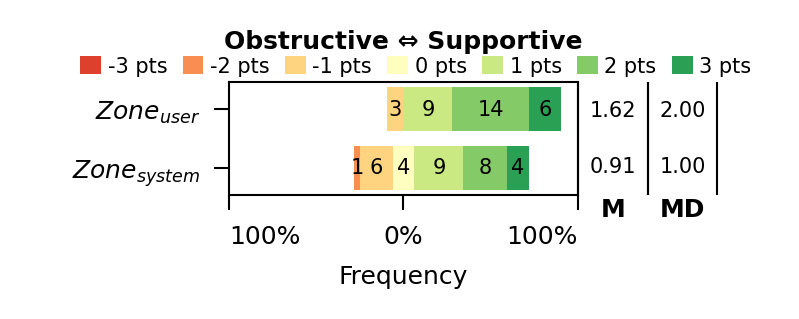

,USERO,SYSO
count,32.000,32.000
mean,1.625,0.906
median,2.000,1.000
mode,2.000,1.000
freq,14.000,9.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,Wilcoxon,44.0,0.012,0.619


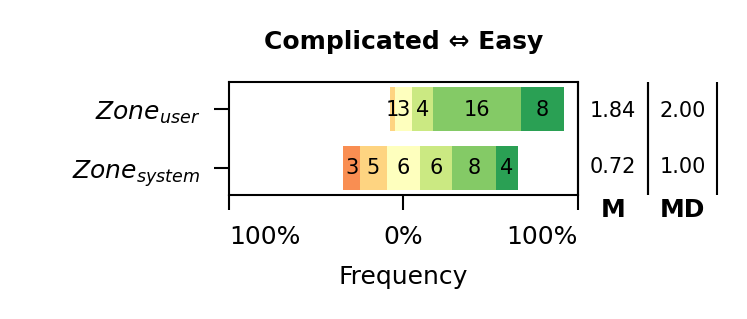

,USERO,SYSO
count,32.000,32.000
mean,1.844,0.719
median,2.000,1.000
mode,2.000,2.000
freq,16.000,8.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,Wilcoxon,22.5,0.002,0.786


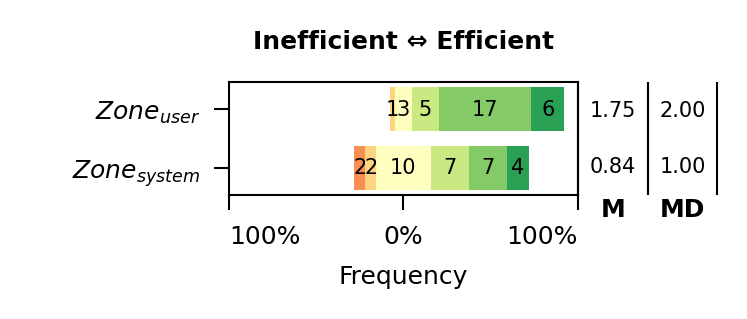

,USERO,SYSO
count,32.00,32.000
mean,1.75,0.844
median,2.00,1.000
mode,2.00,0.000
freq,17.00,10.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,Wilcoxon,35.5,0.001,0.743


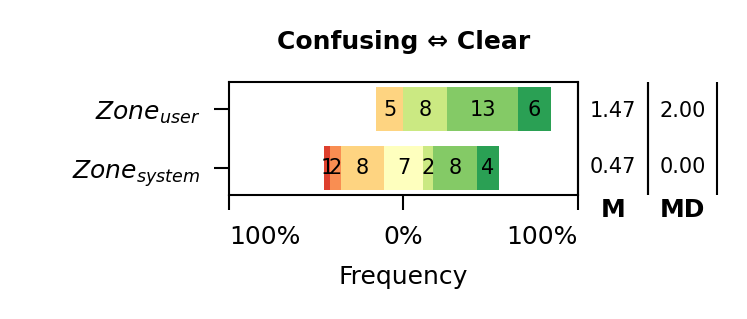

,USERO,SYSO
count,32.000,32.000
mean,1.469,0.469
median,2.000,0.000
mode,2.000,2.000
freq,13.000,8.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,Wilcoxon,57.5,0.008,0.617


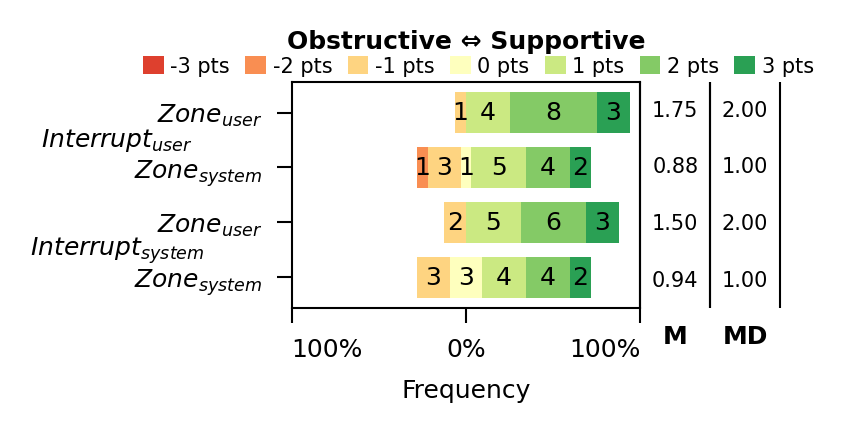

,USERI-USERO,USERI-SYSO,SYSI-USERO,SYSI-SYSO
count,16.00,16.000,16.0,16.000
mean,1.75,0.875,1.5,0.938
median,2.00,1.000,2.0,1.000
mode,2.00,1.000,2.0,1.000
freq,8.00,5.000,6.0,4.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERI-USERO | USERI-SYSO | SYSI-USERO | SYSI-SYSO,16,Friedman,5.761,0.124,0.120
1,USERI-USERO|USERI-SYSO,16,Wilcoxon,3.000,0.087,0.867
2,USERI-USERO|SYSI-USERO,16,Wilcoxon,20.500,1.000,0.255
3,USERI-SYSO|SYSI-SYSO,16,Wilcoxon,26.500,1.000,0.036
4,SYSI-USERO|SYSI-SYSO,16,Wilcoxon,22.000,0.752,0.436


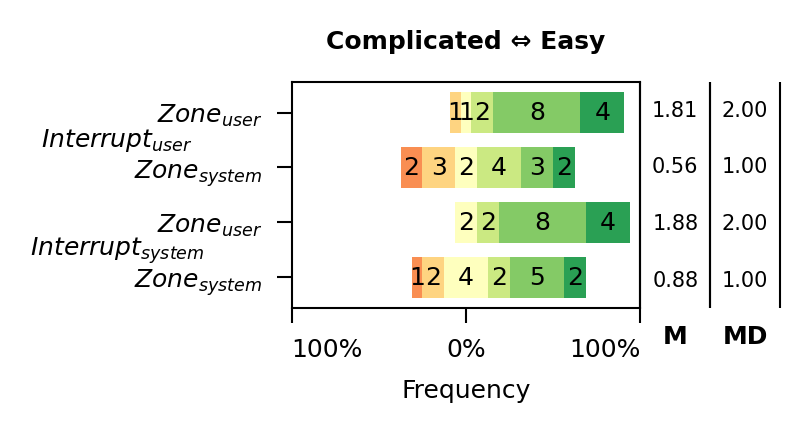

,USERI-USERO,USERI-SYSO,SYSI-USERO,SYSI-SYSO
count,16.000,16.000,16.000,16.000
mean,1.812,0.562,1.875,0.875
median,2.000,1.000,2.000,1.000
mode,2.000,1.000,2.000,2.000
freq,8.000,4.000,8.000,5.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERI-USERO | USERI-SYSO | SYSI-USERO | SYSI-SYSO,16,Friedman,9.683,0.021,0.202
1,USERI-USERO|USERI-SYSO,16,Wilcoxon,6.500,0.078,0.803
2,USERI-USERO|SYSI-USERO,16,Wilcoxon,38.500,1.000,-0.013
3,USERI-SYSO|SYSI-SYSO,16,Wilcoxon,25.000,1.000,-0.242
4,SYSI-USERO|SYSI-SYSO,16,Wilcoxon,5.000,0.167,0.778


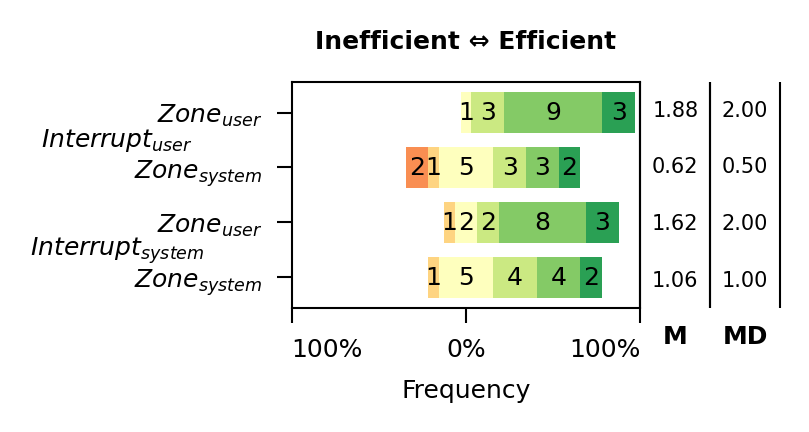

,USERI-USERO,USERI-SYSO,SYSI-USERO,SYSI-SYSO
count,16.000,16.000,16.000,16.000
mean,1.875,0.625,1.625,1.062
median,2.000,0.500,2.000,1.000
mode,2.000,0.000,2.000,0.000
freq,9.000,5.000,8.000,5.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERI-USERO | USERI-SYSO | SYSI-USERO | SYSI-SYSO,16,Friedman,8.444,0.038,0.176
1,USERI-USERO|USERI-SYSO,16,Wilcoxon,1.500,0.031,0.945
2,USERI-USERO|SYSI-USERO,16,Wilcoxon,15.000,1.000,0.333
3,USERI-SYSO|SYSI-SYSO,16,Wilcoxon,12.000,0.849,-0.467
4,SYSI-USERO|SYSI-SYSO,16,Wilcoxon,22.500,0.423,0.505


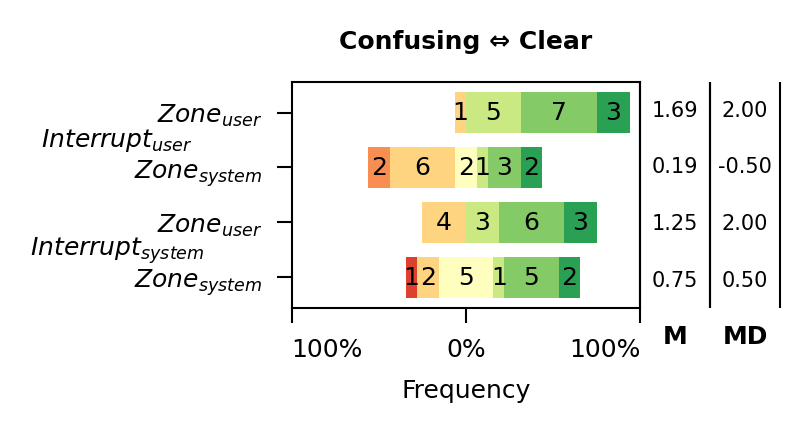

,USERI-USERO,USERI-SYSO,SYSI-USERO,SYSI-SYSO
count,16.000,16.000,16.00,16.00
mean,1.688,0.188,1.25,0.75
median,2.000,-0.500,2.00,0.50
mode,2.000,-1.000,2.00,0.00
freq,7.000,6.000,6.00,5.00


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERI-USERO | USERI-SYSO | SYSI-USERO | SYSI-SYSO,16,Friedman,7.476,0.058,0.156
1,USERI-USERO|USERI-SYSO,16,Wilcoxon,2.000,0.025,0.939
2,USERI-USERO|SYSI-USERO,16,Wilcoxon,20.000,0.508,0.487
3,USERI-SYSO|SYSI-SYSO,16,Wilcoxon,13.500,0.580,-0.509
4,SYSI-USERO|SYSI-SYSO,16,Wilcoxon,32.500,1.000,0.286


In [13]:
PLOT_SAVING = True
from IPython.display import display, HTML

factor_names_list = [ ['Modality'], ['Task', 'Modality']]

variable_name_list = [
'OBSTRUCTIVE⇔SUPPORTIVE', 'COMPLICATED⇔EASY', 'INEFFICIENT⇔EFFICIENT', 'CONFUSING⇔CLEAR',
#'BORING⇔EXCITING', 'NOT_INTERESTING⇔INTERESTING', 'CONVENTIONAL⇔INVENTIVE', 'USUAL⇔LEADING_EDGE',
]

variable_range_list = [
    (1,7), (1,7), (1,7), (1,7),
#    (1,7), (1,7), (1,7), (1,7),
]

variable_legend_hide_list = [
    False, True, True, True,
#    True, True, True, True,
    ]

variable_reverse_list = [
    False, False, False, False,
#   False, False, False, False
]
new_variable_name_list = [
    'Obstructive ⇔ Supportive', 'Complicated ⇔ Easy', 'Inefficient ⇔ Efficient', 'Confusing ⇔ Clear',
#    'Boring ⇔ Exciting', 'Not interesting ⇔ Interesting', 'Conventional ⇔ Inventive', 'Usual ⇔ Leading Edge'
]

new_variable_range_list = [
    (-3,3), (-3,3), (-3,3),  (-3,3), 
#    (-3,3), (-3,3), (-3,3), (-3,3), 
]

filename_body_list = [
    'Supportiveness', 'Simplicity', 'Efficiency', 'Clarity',
    #'Excitement', 'Interest', 'Inventiveness', 'Modernity'
]

desc_stats_of_interest = ['count', 'mean', 'median', 'mode', 'freq']

for factor_names in factor_names_list:
    for variable_index, variable_name in enumerate(variable_name_list):
        # fetch useful information
        variable_reverse = variable_reverse_list[variable_index]
        new_variable_name = new_variable_name_list[variable_index]
        (var_min, var_max) = variable_range_list[variable_index]
        (new_var_min, new_var_max) = new_variable_range_list[variable_index]
        # scoping of global dataframe
        df_var = df_qual.loc[::,factor_names + [variable_name]].reset_index()
        # centering values and inversing them
        var_length = var_max - var_min
        new_var_length = new_var_max - new_var_min
        df_var_coeff =  1 - ((var_max - df_var.loc[:, variable_name])/var_length)
        df_var.loc[:, variable_name] = new_var_min + df_var_coeff * new_var_length
        if variable_reverse:
            df_var.loc[:, variable_name] = new_var_min + (1 - df_var_coeff) * new_var_length
            
        # generate a title
        variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
        display(HTML("<h1>%s</h1>" %(variable_title)))
        # renaming columns 
        df_var_columns = {}
        for factor_index, factor_name in enumerate(factor_names):
            df_var_columns[factor_name] = "factor%s" % factor_index
        df_var_columns[variable_name] = "variable"
        df_var.rename(columns=df_var_columns, inplace=True)
        factor_columns = [factor_column for factor_column in df_var.columns.values if "factor" in factor_column]
        # plotting figure
        if len(factor_columns) == 1:
            fig_quant = statistics.Statistics.plotOrdinalMonoFactor(
                df_var,
                figure_size = (1.5, 0.5),
                figure_dpi = 300,
                legend_hide = variable_legend_hide_list[variable_index],
                legend_bbox_anchor = (0.55, 1.14),
                table_bbox = [1.00, -0.25, 0.4, 1.25],
                table_head_height = 0.5,
                table_row_height = 1,
                table_column_width = 1,
                table_head_size = 6,
                table_cell_size = 5,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                variable_lim = new_variable_range_list[variable_index],
                )
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()

        if len(factor_columns) == 2:
            fig_quant = statistics.Statistics.plotOrdinalDualFactors(
                df_var,
                figure_size = (1.5, 1),
                figure_dpi = 300,
                legend_hide = variable_legend_hide_list[variable_index],
                legend_bbox_anchor = (0.55, 1.07),
                table_bbox = [1.00, -0.25, 0.4, 1.25],
                table_head_height = 1,
                table_row_height = 1,
                table_head_size = 6,
                table_cell_size = 5,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                factor2_columns = factor_values_labels_map[factor_names[1]]['values'],
                factor2_labels = factor_values_labels_map[factor_names[1]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                variable_lim = new_variable_range_list[variable_index],
                )
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()
        
        
        # descriptive statistics
        
        # Pivot factor x variables
        
        df_var_cpy = df_var.copy()
        df_var_cpy["factor"] = df_var_cpy[factor_columns].apply(lambda x: "-".join([str(_) for _ in x]), axis=1)
        df_var_cpy.drop(columns=factor_columns, inplace=True)
        multifactor_values = df_var_cpy["factor"].unique().tolist()
        df_var_pivot = df_var_cpy.pivot(index="index", columns="factor", values="variable")

        df_var_pivot = pd.DataFrame()
        for multifactor_value in multifactor_values:
            raw_values = df_var_cpy.loc[df_var_cpy['factor'] == multifactor_value, 'variable'].values
            df_var_col = pd.DataFrame({multifactor_value:raw_values})
            df_var_pivot = pd.concat([df_var_pivot,df_var_col],  axis=1)
            
        # descriptive statistics
        df_stats_desc = statistics.Statistics.describePlus(df_var_pivot).round(3)
        display(df_stats_desc.loc[desc_stats_of_interest, ::])
        
        df_stats_infer = statistics.Statistics.inferQualOrdinalPaired(df_var_pivot, variable_range_list[variable_index]).round(3)
        display(df_stats_infer)



# ANALYSIS OF PERCEIVED SAFETY ITEMS

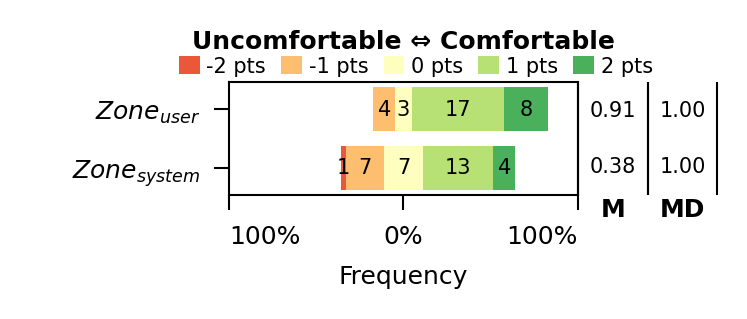

,USERO,SYSO
count,32.000,32.000
mean,0.906,0.375
median,1.000,1.000
mode,1.000,1.000
freq,17.000,13.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,Wilcoxon,45.0,0.022,0.571


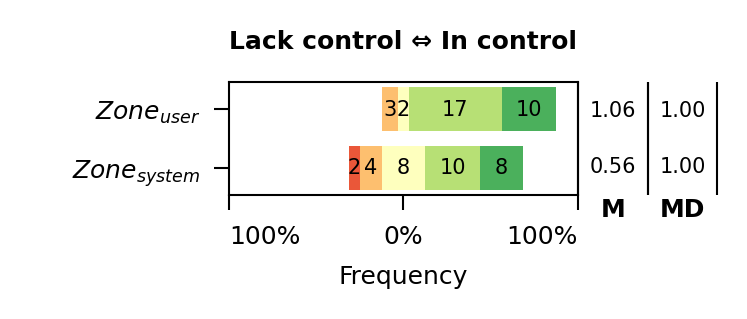

,USERO,SYSO
count,32.000,32.000
mean,1.062,0.562
median,1.000,1.000
mode,1.000,1.000
freq,17.000,10.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,Wilcoxon,34.0,0.023,0.602


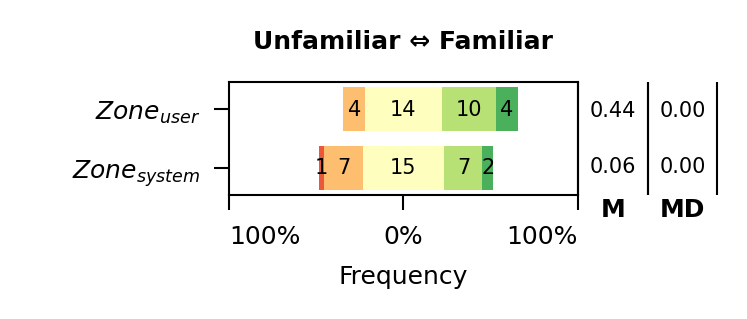

,USERO,SYSO
count,32.000,32.000
mean,0.438,0.062
median,0.000,0.000
mode,0.000,0.000
freq,14.000,15.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,Wilcoxon,22.5,0.011,0.669


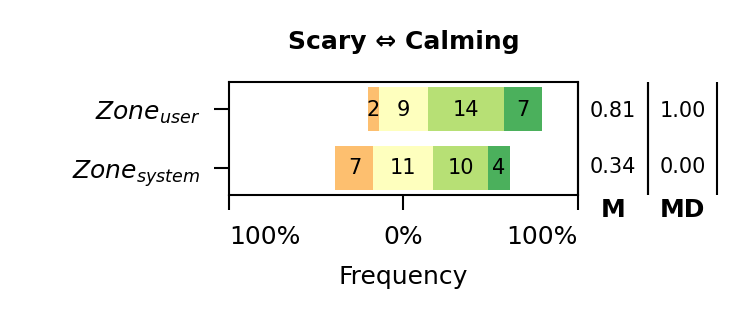

,USERO,SYSO
count,32.000,32.000
mean,0.812,0.344
median,1.000,0.000
mode,1.000,0.000
freq,14.000,11.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERO|SYSO,32,Wilcoxon,18.0,0.008,0.735


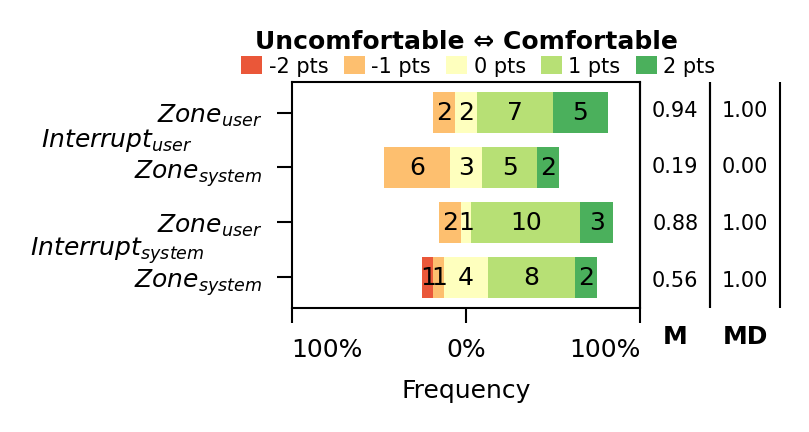

,USERI-USERO,USERI-SYSO,SYSI-USERO,SYSI-SYSO
count,16.000,16.000,16.000,16.000
mean,0.938,0.188,0.875,0.562
median,1.000,0.000,1.000,1.000
mode,1.000,-1.000,1.000,1.000
freq,7.000,6.000,10.000,8.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERI-USERO | USERI-SYSO | SYSI-USERO | SYSI-SYSO,16,Friedman,6.69,0.082,0.139
1,USERI-USERO|USERI-SYSO,16,Wilcoxon,7.50,0.170,0.727
2,USERI-USERO|SYSI-USERO,16,Wilcoxon,29.50,1.000,0.106
3,USERI-SYSO|SYSI-SYSO,16,Wilcoxon,18.00,0.709,-0.455
4,SYSI-USERO|SYSI-SYSO,16,Wilcoxon,17.00,1.000,0.382


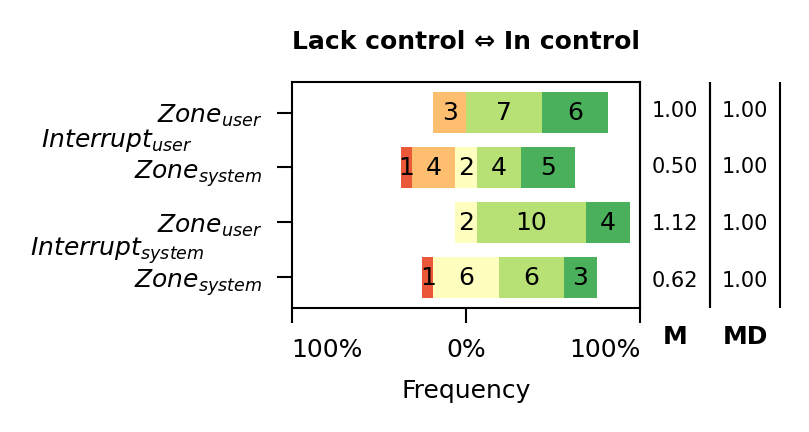

,USERI-USERO,USERI-SYSO,SYSI-USERO,SYSI-SYSO
count,16.0,16.0,16.000,16.000
mean,1.0,0.5,1.125,0.625
median,1.0,1.0,1.000,1.000
mode,1.0,2.0,1.000,0.000
freq,7.0,5.0,10.000,6.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERI-USERO | USERI-SYSO | SYSI-USERO | SYSI-SYSO,16,Friedman,4.161,0.245,0.087
1,USERI-USERO|USERI-SYSO,16,Wilcoxon,7.500,0.621,0.583
2,USERI-USERO|SYSI-USERO,16,Wilcoxon,41.000,1.000,-0.099
3,USERI-SYSO|SYSI-SYSO,16,Wilcoxon,17.500,1.000,-0.222
4,SYSI-USERO|SYSI-SYSO,16,Wilcoxon,10.500,0.332,0.618


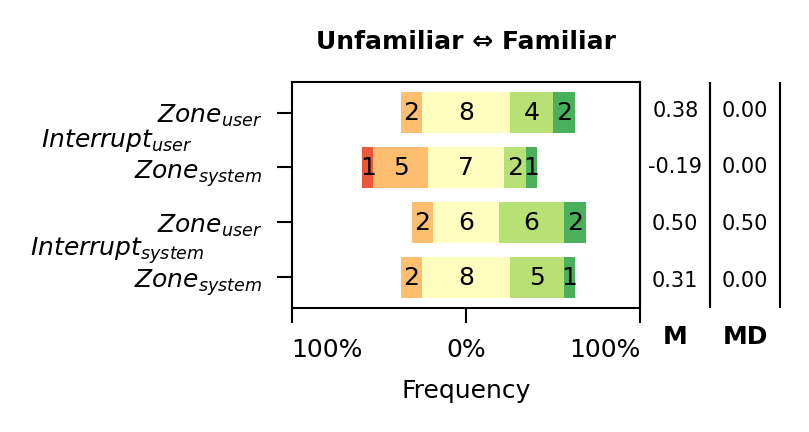

,USERI-USERO,USERI-SYSO,SYSI-USERO,SYSI-SYSO
count,16.000,16.000,16.0,16.000
mean,0.375,-0.188,0.5,0.312
median,0.000,0.000,0.5,0.000
mode,0.000,0.000,1.0,0.000
freq,8.000,7.000,6.0,8.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERI-USERO | USERI-SYSO | SYSI-USERO | SYSI-SYSO,16,Friedman,9.289,0.026,0.194
1,USERI-USERO|USERI-SYSO,16,Wilcoxon,0.000,0.071,1.000
2,USERI-USERO|SYSI-USERO,16,Wilcoxon,18.000,1.000,-0.200
3,USERI-SYSO|SYSI-SYSO,16,Wilcoxon,0.000,0.122,-1.000
4,SYSI-USERO|SYSI-SYSO,16,Wilcoxon,15.000,1.000,0.333


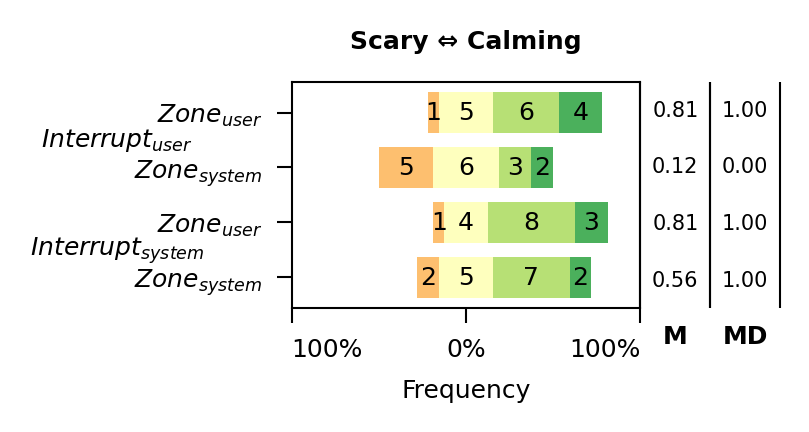

,USERI-USERO,USERI-SYSO,SYSI-USERO,SYSI-SYSO
count,16.000,16.000,16.000,16.000
mean,0.812,0.125,0.812,0.562
median,1.000,0.000,1.000,1.000
mode,1.000,0.000,1.000,1.000
freq,6.000,6.000,8.000,7.000


,Comparison,N,Test,Statistic,pValue,effectSize
0,USERI-USERO | USERI-SYSO | SYSI-USERO | SYSI-SYSO,16,Friedman,7.545,0.056,0.157
1,USERI-USERO|USERI-SYSO,16,Wilcoxon,3.000,0.083,0.867
2,USERI-USERO|SYSI-USERO,16,Wilcoxon,10.500,1.000,0.000
3,USERI-SYSO|SYSI-SYSO,16,Wilcoxon,8.000,0.322,-0.644
4,SYSI-USERO|SYSI-SYSO,16,Wilcoxon,7.000,0.961,0.500


In [14]:
PLOT_SAVING = True
factor_names_list = [['Modality'], ['Task', 'Modality']]



variable_name_list = [
    #'ANXIOUS⇔RELAXED', 'SCARY⇔CALMING', 'UNCOMFORTABLE⇔COMFORTABLE', 
    #'LACK_CONTROL⇔IN_CONTROL', 'THREATENING⇔SAFE', 'UNFAMILIAR⇔FAMILIAR', 'UNRELIABLE⇔RELIABLE', 
    #'INSECURE⇔SECURE', 'ANXIOUS⇔RELAXED', 'UNCOMFORTABLE⇔COMFORTABLE', 'LACK_CONTROL⇔IN_CONTROL',
    #'THREATENING⇔SAFE', 'UNFAMILIAR⇔FAMILIAR', 'UNRELIABLE⇔RELIABLE', 'SCARY⇔CALMING',
    'UNCOMFORTABLE⇔COMFORTABLE', 'LACK_CONTROL⇔IN_CONTROL', 'UNFAMILIAR⇔FAMILIAR', 'SCARY⇔CALMING'
]


variable_range_list = [
    #(1,5), (1,5), (1,5), (1,5),
    (1,5), (1,5), (1,5), (1,5)
]
variable_legend_hide_list = [
    #False, False, False, False
    False, True, True, True
]

variable_reverse_list = [
    #False, False, False, False,
    False, False, False, False
]
new_variable_name_list = [
    #'Anxious ⇔ Relaxed', 'Scary ⇔ Calming', 'Uncomfortable ⇔ Comfortable',
    #'Insecure ⇔ Secure', 'Anxious ⇔ Relaxed', 'Uncomfortable ⇔ Comfortable', 'Lack control ⇔ In control',
    #'Threatening ⇔ Safe', 'Unfamiliar ⇔ Familiar', 'Unreliable ⇔ Reliable', 'Scary ⇔ Calming',
    'Uncomfortable ⇔ Comfortable', 'Lack control ⇔ In control', 'Unfamiliar ⇔ Familiar', 'Scary ⇔ Calming'
]

new_variable_range_list = [
    #(-2,2), (-2,2), (-2,2),  (-2,2),
     (-2,2), (-2,2), (-2,2), (-2,2),
]

filename_body_list = [
    #'Anxious ⇔ Relaxed', 'Scary ⇔ Calming', 'Uncomfortable ⇔ Comfortable',
    #'Security', 'Relaxation', 'Comfort', 'Control',
    #'Safety', 'Familiar', 'Reliability', 'Calmness',
    'Comfort', 'Control', 'Familiar', 'Calmness',
]

desc_stats_of_interest = ['count', 'mean', 'median', 'mode', 'freq']

for factor_names in factor_names_list:
    for variable_index, variable_name in enumerate(variable_name_list):
        # fetch useful information
        variable_reverse = variable_reverse_list[variable_index]
        new_variable_name = new_variable_name_list[variable_index]
        (var_min, var_max) = variable_range_list[variable_index]
        (new_var_min, new_var_max) = new_variable_range_list[variable_index]
        if factor_names[0] != 'All':
            # scoping of global dataframe
            df_var = df_qual.loc[::,factor_names + [variable_name]].reset_index()
            # centering values and inversing them
            var_length = var_max - var_min
            new_var_length = new_var_max - new_var_min
            df_var_coeff =  1 - ((var_max - df_var.loc[:, variable_name])/var_length)
            df_var.loc[:, variable_name] = new_var_min + df_var_coeff * new_var_length
            if variable_reverse:
                df_var.loc[:, variable_name] = new_var_min + (1 - df_var_coeff) * new_var_length
            # generate a title
            variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
            display(HTML("<h1>%s</h1>" %(variable_title)))
            # renaming columns 
            df_var_columns = {}
            for factor_index, factor_name in enumerate(factor_names):
                df_var_columns[factor_name] = "factor%s" % factor_index
            df_var_columns[variable_name] = "variable"
            df_var.rename(columns=df_var_columns, inplace=True)
            factor_columns = [factor_column for factor_column in df_var.columns.values if "factor" in factor_column]
            # plotting figure
            if len(factor_columns) == 1:
                fig_quant = statistics.Statistics.plotOrdinalMonoFactor(
                    df_var,
                    figure_size = (1.5, 0.5),
                    figure_dpi = 300,
                    legend_hide = variable_legend_hide_list[variable_index],
                    legend_bbox_anchor = (0.55, 1.14),
                    table_bbox = [1.00, -0.25, 0.4, 1.25],
                    table_head_height = 0.5,
                    table_row_height = 1,
                    table_column_width = 1,
                    table_head_size = 6,
                    table_cell_size = 5,
                    factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                    factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                    variable_column = 'variable',
                    variable_label = new_variable_name_list[variable_index],
                    variable_lim = new_variable_range_list[variable_index],
                    )
                if PLOT_SAVING:
                    filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                    fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
                    plt.show()
            if len(factor_columns) == 2:
                fig_quant = statistics.Statistics.plotOrdinalDualFactors(
                    df_var,
                    figure_size = (1.5, 1),
                    figure_dpi = 300,
                    legend_hide = variable_legend_hide_list[variable_index],
                    legend_bbox_anchor = (0.55, 1.07),
                    table_bbox = [1.00, -0.25, 0.4, 1.25],
                    table_head_height = 1,
                    table_row_height = 1,
                    table_head_size = 6,
                    table_cell_size = 5,
                    factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                    factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                    factor2_columns = factor_values_labels_map[factor_names[1]]['values'],
                    factor2_labels = factor_values_labels_map[factor_names[1]]['labels'],
                    variable_column = 'variable',
                    variable_label = new_variable_name_list[variable_index],
                    variable_lim = new_variable_range_list[variable_index],
                    )
                if PLOT_SAVING:
                    filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                    fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
                    plt.show()
            
            
            # descriptive statistics
            
            # Pivot factor x variables
            
            df_var_cpy = df_var.copy()
            df_var_cpy["factor"] = df_var_cpy[factor_columns].apply(lambda x: "-".join([str(_) for _ in x]), axis=1)
            df_var_cpy.drop(columns=factor_columns, inplace=True)
            multifactor_values = df_var_cpy["factor"].unique().tolist()
            df_var_pivot = df_var_cpy.pivot(index="index", columns="factor", values="variable")

            df_var_pivot = pd.DataFrame()
            for multifactor_value in multifactor_values:
                raw_values = df_var_cpy.loc[df_var_cpy['factor'] == multifactor_value, 'variable'].values
                df_var_col = pd.DataFrame({multifactor_value:raw_values})
                df_var_pivot = pd.concat([df_var_pivot,df_var_col],  axis=1)
                
            # descriptive statistics
            df_stats_desc = statistics.Statistics.describePlus(df_var_pivot).round(3)
            display(df_stats_desc.loc[desc_stats_of_interest, :])
            
            df_stats_infer = statistics.Statistics.inferQualOrdinalPaired(df_var_pivot, variable_range_list[variable_index]).round(3)
            display(df_stats_infer)
        else:
            df_var = df_qual.loc[::, [variable_name]]
            # centering values and inversing them
            var_length = var_max - var_min
            new_var_length = new_var_max - new_var_min
            df_var_coeff =  1 - ((var_max - df_var.loc[:, variable_name])/var_length)
            df_var.loc[:, variable_name] = new_var_min + df_var_coeff * new_var_length
            if variable_reverse:
                df_var.loc[:, variable_name] = new_var_min + (1 - df_var_coeff) * new_var_length
            print("%s => %s" %(' x '.join(factor_names), new_variable_name))
            df_stats_desc = statistics.Statistics.describePlus(df_var).round(3)
            display(df_stats_desc.loc[desc_stats_of_interest, :])


# ANALYSIS OF BIOSIGNALS

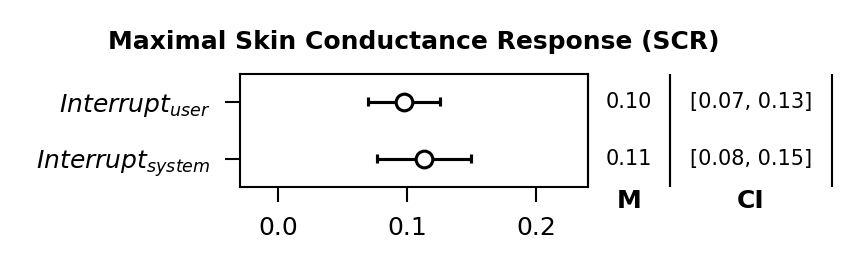

,SYSI,USERI
count,264.000,278.000
mean,0.113,0.098
cil,0.080,0.070
cih,0.150,0.130


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,SYSI|USERI,288,False,Wilcoxon,15478.0,0.475,-0.052


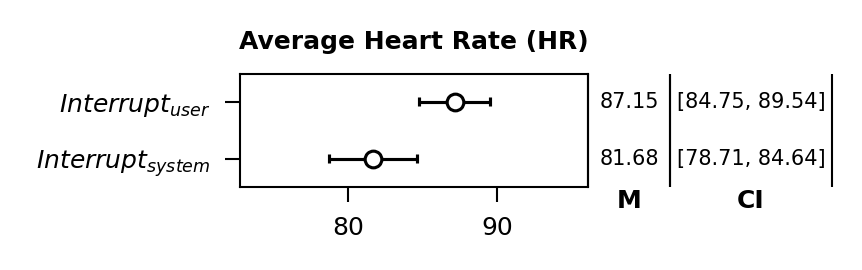

,SYSI,USERI
count,288.000,288.000
mean,81.677,87.149
cil,78.830,84.710
cih,84.440,89.470


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,SYSI|USERI,288,False,Wilcoxon,14592.0,0.0,-0.299


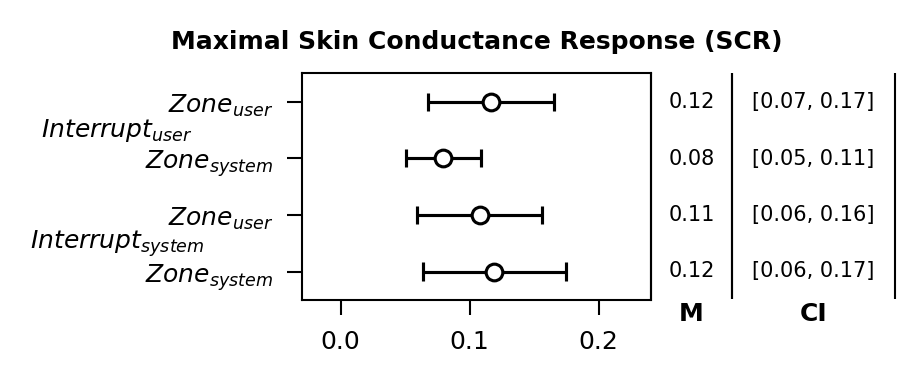

,SYSI-USERO,SYSI-SYSO,USERI-USERO,USERI-SYSO
count,133.000,131.000,135.000,143.00
mean,0.108,0.119,0.117,0.08
cil,0.070,0.070,0.070,0.05
cih,0.160,0.180,0.180,0.11


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,SYSI-USERO | SYSI-SYSO | USERI-USERO | USERI-SYSO,144,False,Friedman,3.232,0.357,0.009
1,SYSI-USERO|SYSI-SYSO,144,False,Wilcoxon,3307.000,1.000,0.118
2,SYSI-USERO|USERI-USERO,144,False,Wilcoxon,3836.000,1.000,0.026
3,SYSI-SYSO|USERI-SYSO,144,False,Wilcoxon,3710.000,0.815,-0.129
4,USERI-USERO|USERI-SYSO,144,False,Wilcoxon,4374.000,1.000,0.033


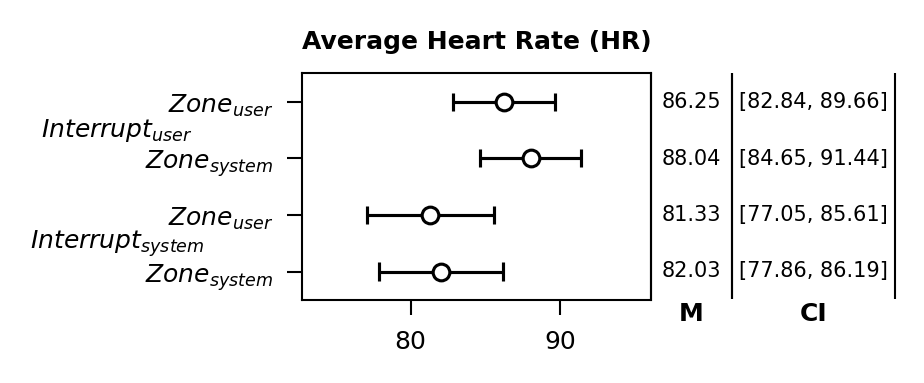

,SYSI-USERO,SYSI-SYSO,USERI-USERO,USERI-SYSO
count,144.000,144.000,144.000,144.000
mean,81.328,82.025,86.253,88.045
cil,76.980,77.630,82.970,84.830
cih,85.410,86.080,89.470,91.430


,Comparison,N,Normality,Test,Statistic,pValue,effectSize
0,SYSI-USERO | SYSI-SYSO | USERI-USERO | USERI-SYSO,144,False,Friedman,17.3,0.001,0.040
1,SYSI-USERO|SYSI-SYSO,144,False,Wilcoxon,4565.0,0.767,0.125
2,SYSI-USERO|USERI-USERO,144,False,Wilcoxon,3999.0,0.060,-0.234
3,SYSI-SYSO|USERI-SYSO,144,False,Wilcoxon,3333.0,0.001,-0.361
4,USERI-USERO|USERI-SYSO,144,False,Wilcoxon,4738.0,1.000,-0.092


In [16]:
PLOT_SAVING = True
from IPython.display import display, HTML
# Compute UEQ-S 

factor_names_list = [['Task'], ['Task', 'Modality']]
variable_name_list = ['EDA_Response_Max', 'BVP_Rate_Mean']
new_variable_name_list = ['Maximal Skin Conductance Response (SCR)', 'Average Heart Rate (HR)']
filename_body_list = ['Maximal Skin Conductance Response', 'Average Heart Rate']
desc_stats_of_interest = ['count', 'mean', 'cil', 'cih']

for factor_names in factor_names_list:
    for variable_index, variable_name in enumerate(variable_name_list):
        # generate a title
        variable_title = '[%s] %s' %(' x '.join(factor_names), filename_body_list[variable_index])
        display(HTML("<h1>%s</h1>" %(variable_title)))
        # scope dataframe
        df_var = df_quant.loc[::,factor_names + [variable_name]].reset_index()
        # renaming columns 
        df_var_columns = {}
        for factor_index, factor_name in enumerate(factor_names):
            df_var_columns[factor_name] = "factor%s" % factor_index
        df_var_columns[variable_name] = "variable"
        df_var.rename(columns=df_var_columns, inplace=True)
        factor_columns = [factor_column for factor_column in df_var.columns.values if "factor" in factor_column]
        # # plotting figure
        # if len(factor_columns) == 1:
        #     fig_quant = statistics.Statistics.plotOrdinalMonoFactor(
        #         df_var,
        #         figure_size = (2, 1),
        #         figure_dpi = 300,
        #         factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
        #         factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
        #         variable_column = 'variable',
        #         variable_label = new_variable_name_list[variable_index],
        #         variable_lim = new_variable_range_list[variable_index],
        #         )
        #     plt.show()

        if len(factor_columns) == 1:
            fig_quant = statistics.Statistics.plotQuantMonoFactor(
                df_var,
                figure_size = (1.5, 0.5),
                figure_dpi = 300,
                table_bbox = [1.0, -0.25, 0.7, 1.25],
                table_head_size = 6,
                table_cell_size = 5,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = None
                )
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()

        if len(factor_columns) == 2:
            fig_quant = statistics.Statistics.plotQuantDualFactors(
                df_var,
                figure_size = (1.5, 1),
                figure_dpi = 300,
                table_bbox = [1.0, -0.12, 0.7, 1.12],
                table_head_height = 0.5,
                table_row_height = 1,
                table_head_size = 6,
                table_cell_size = 5,
                factor1_columns = factor_values_labels_map[factor_names[0]]['values'],
                factor1_labels = factor_values_labels_map[factor_names[0]]['labels'],
                factor2_columns = factor_values_labels_map[factor_names[1]]['values'],
                factor2_labels = factor_values_labels_map[factor_names[1]]['labels'],
                variable_column = 'variable',
                variable_label = new_variable_name_list[variable_index],
                df_benchmark = None
                )
            if PLOT_SAVING:
                filename = filename_head + ' - ' + variable_title + ' .' + filename_extension
                fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
            plt.show()
        
        # descriptive statistics
        
        # Pivot factor x variables

        df_var_cpy = df_var.copy()
        df_var_cpy["factor"] = df_var_cpy[factor_columns].apply(lambda x: "-".join([str(_) for _ in x]), axis=1)
        df_var_cpy.drop(columns=factor_columns, inplace=True)
        multifactor_values = df_var_cpy["factor"].unique().tolist()
        df_var_pivot = df_var_cpy.pivot(index="index", columns="factor", values="variable")

        df_var_pivot = pd.DataFrame()
        for multifactor_value in multifactor_values:
            raw_values = df_var_cpy.loc[df_var_cpy['factor'] == multifactor_value, 'variable'].values
            df_var_col = pd.DataFrame({multifactor_value:raw_values})
            df_var_pivot = pd.concat([df_var_pivot,df_var_col],  axis=1)
            
        # descriptive statistics
        df_stats_desc = statistics.Statistics.describePlus(df_var_pivot).round(3)
        display(df_stats_desc.loc[desc_stats_of_interest, ::])
        
        df_stats_infer = statistics.Statistics.inferQuantPaired(df_var_pivot, normality_assumption = 'false').round(3)
        display(df_stats_infer)

### Statistics and Plotting for UEQ-S items

In [8]:
PLOT_SAVING = True
# Compute UEQ-S 

task_values = ['USERI', 'SYSI']
task_labels = ['Intent_{user}', 'Intent_{system}']
modality_values = ['USERO', 'SYSO']
modality_labels = ['Zone_{human}', 'Zone_{pin}']

variable_values = [
    'OBSTRUCTIVE⇔SUPPORTIVE', 'COMPLICATED⇔EASY', 'INEFFICIENT⇔EFFICIENT', 'CONFUSING⇔CLEAR',
    'BORING⇔EXCITING', 'NOT_INTERESTING⇔INTERESTING', 'CONVENTIONAL⇔INVENTIVE', 'USUAL⇔LEADING_EDGE',
]

variable_ranges = [
    (-3,3), (-3,3), (-3,3), (-3,3),
    (-3,3), (-3,3), (-3,3), (-3,3),
]

variable_reverses = [
    False, False, False, False,
    False, False, False, False
]
variable_labels = [
    'Obstructive ⇔ Supportive', 'Complicated ⇔ Easy', 'Inefficient ⇔ Efficient', 'Confusing ⇔ Clear',
    'Boring ⇔ Exciting', 'Not interesting ⇔ Interesting', 'Conventional ⇔ Inventive', 'Usual ⇔ Leading edge',
]
desc_stats_of_interest = ['count', 'median', 'mode', 'freq']
filename_head = 'study2'
filename_bodies = [
    'supportive', 'easy', 'efficient', 'clear', 
    'exciting', 'interesting', 'inventive', 'leading edge'
]
filename_extension = 'jpg'

stats_df = pd.DataFrame(columns = ['median'])
float_precision = 2

for variable_index, variable_value  in enumerate(variable_values):
    # fetch dependent variable
    df_variable = df_qual.loc[::, ['Task', 'Modality', variable_value]]
    # change the range of the variable
    (x_min, x_max) = variable_ranges[variable_index]
    df_variable.loc[::, [variable_value]] += (x_min - 1)
    # plotting figure
    fig_quant = statistics.Statistics.plotQualOrdinalPaired(
        df_variable,
        figure_size = (2, 1),
        figure_dpi = 300,
        task_columns = task_values,
        task_labels = task_labels,
        modality_columns = modality_values,
        modality_labels = modality_labels,
        variable_column = variable_values[variable_index],
        variable_label = variable_labels[variable_index],
        variable_lim = variable_ranges[variable_index],
        variable_reverse = variable_reverses[variable_index],
        )
    if PLOT_SAVING:
        filename = filename_head + '-' + filename_bodies[variable_index] + '.' + filename_extension
        fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
    plt.show()
    # compute statistic
    df_variable['Task'] = df_variable['Task'] + '-' + df_variable['Modality']
    df_variable.drop(columns=['Modality'], inplace=True)
    df_variable.rename(columns={'Task':'Factor', variable_value:'Variable'}, inplace=True)
    df_variable_columns = df_variable['Factor'].unique()
    df_variable_pivot = pd.DataFrame()
    for df_variable_column in df_variable_columns:
        raw_values = df_variable.loc[df_variable['Factor'] == df_variable_column, 'Variable'].values
        df_var_col = pd.DataFrame({df_variable_column:raw_values})
        df_variable_pivot = pd.concat([df_variable_pivot,df_var_col],  axis=1)

    df_stats_desc = statistics.Statistics.describePlus(df_variable_pivot).round(2)
    display(df_stats_desc.loc[desc_stats_of_interest, ::])
    df_stats_infer = statistics.Statistics.inferQualOrdinalPaired(df_variable_pivot, variable_ranges[variable_index]).round(3)
    display(df_stats_infer)



AttributeError: type object 'Statistics' has no attribute 'plotQualOrdinalPaired'

### Statistics and Plotting for Perceived Safety Questionnaire (PSQ)

In [ ]:
PLOT_SAVING = True
# Compute UEQ-S 

task_values = ['USERI', 'SYSI']
task_labels = ['Intent_{user}', 'Intent_{system}']
modality_values = ['USERO', 'SYSO']
modality_labels = ['Zone_{human}', 'Zone_{pin}']

variable_values = [
    'INSECURE⇔SECURE', 'ANXIOUS⇔RELAXED', 'UNCOMFORTABLE⇔COMFORTABLE', 'LACK_CONTROL⇔IN_CONTROL',
    'THREATENING⇔SAFE', 'UNFAMILIAR⇔FAMILIAR', 'UNRELIABLE⇔RELIABLE', 'SCARY⇔CALMING',
]

variable_ranges = [
    (-2,2), (-2,2), (-2,2), (-2,2),
    (-2,2), (-2,2), (-2,2), (-2,2),
]

variable_reverses = [
    False, False, False, False,
    False, False, False, False
]
variable_labels = [
    'Insecure ⇔ Secure', 'Anxious ⇔ Relaxed', 'Uncomfortable ⇔ Comfortable', 'Lack control ⇔ In control',
    'Threatening ⇔ Safe', 'Unfamiliar ⇔ Familiar', 'Unreliable ⇔ Reliable', 'Scary ⇔ Calming',
]

desc_stats_of_interest = ['count', 'median', 'mode', 'freq']
filename_head = 'study2'
filename_bodies = [
    'secure', 'relaxed', 'comfortable', 'control', 
    'safe', 'familiar', 'reliable', 'calming'
]
filename_extension = 'jpg'

stats_df = pd.DataFrame(columns = ['median'])
float_precision = 2

for variable_index, variable_value  in enumerate(variable_values):
    # fetch dependent variable
    df_variable = df_qual.loc[::, ['Task', 'Modality', variable_value]]
    # change the range of the variable
    (x_min, x_max) = variable_ranges[variable_index]
    df_variable.loc[::, [variable_value]] += (x_min - 1)
    # plotting figure
    fig_quant = statistics.Statistics.plotQualOrdinalPaired(
        df_variable,
        figure_size = (2, 1),
        figure_dpi = 300,
        task_columns = task_values,
        task_labels = task_labels,
        modality_columns = modality_values,
        modality_labels = modality_labels,
        variable_column = variable_values[variable_index],
        variable_label = variable_labels[variable_index],
        variable_lim = variable_ranges[variable_index],
        variable_reverse = variable_reverses[variable_index],
        )
    if PLOT_SAVING:
        filename = filename_head + '-' + filename_bodies[variable_index] + '.' + filename_extension
        fig_quant.savefig(filename, bbox_inches='tight', dpi = 300)
    plt.show()
    # compute statistic
    df_variable['Task'] = df_variable['Task'] + '-' + df_variable['Modality']
    df_variable.drop(columns=['Modality'], inplace=True)
    df_variable.rename(columns={'Task':'Factor', variable_value:'Variable'}, inplace=True)
    df_variable_columns = df_variable['Factor'].unique()
    df_variable_pivot = pd.DataFrame()
    for df_variable_column in df_variable_columns:
        raw_values = df_variable.loc[df_variable['Factor'] == df_variable_column, 'Variable'].values
        df_var_col = pd.DataFrame({df_variable_column:raw_values})
        df_variable_pivot = pd.concat([df_variable_pivot,df_var_col],  axis=1)

    df_stats_desc = statistics.Statistics.describePlus(df_variable_pivot).round(2)
    display(df_stats_desc.loc[desc_stats_of_interest, ::])
    df_stats_infer = statistics.Statistics.inferQualOrdinalPaired(df_variable_pivot, variable_ranges[variable_index]).round(3)
    display(df_stats_infer)

